In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
import stc
import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta.ravel()) - np.min(sta.ravel())

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())


def plot_spatio_temporal(sta,dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    if ylabel is not None:
        plt.ylabel(ylabel)
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    print('PSNR = {:.2f}'.format(psnr(sta)))
#     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
    plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=26, width=26, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')

    plt.xlim(-0.5, 3.5)
    box_off()

## load data

In [70]:
data_path = 'data'
dataset = '20201209'

info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))
data = np.load(os.path.join(data_path, dataset + '.npz'))

stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

85

In [71]:
info['cell_type'].value_counts()

ON-OFF     34
ON         29
Unknown    13
OFF         9
Name: cell_type, dtype: int64

In [72]:
idx_unknown = info['cell_type'] == 'ON-OFF'
info[idx_unknown]

,channel,cell_type
2,14a,ON-OFF
4,17a,ON-OFF
5,21a,ON-OFF
6,22a,ON-OFF
9,23b,ON-OFF
11,24b,ON-OFF
13,25b,ON-OFF
14,26a,ON-OFF
15,26b,ON-OFF
16,28a,ON-OFF


## calc STA for an RGC

In [73]:
print(stim.shape)
print(spike_counts.shape)

(27000, 676)
(85, 27000)


In [74]:
# choose a channel

ch_idx = 2    # 14a ON-OFF
# ch_idx = 22   # 33c	ON
# ch_idx = 29   # 37b ON
# ch_idx = 41     # 48b OFF
# ch_idx = 67     # 71c ON


# small p2p
# ch_idx = 81  #85b ON-OFF
#ch_idx = 84 #87b ON

channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

14a ON-OFF


In [75]:
tap=12
spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

In [76]:
sta = np.average(spike_triggered_stim, weights=weights, axis=0)
# sta.shape

print(spike_triggered_stim.shape)



# plot_spatio_temporal(sta, ylabel='STA',
#                      fig_basename=os.path.join('figure', 'sta', channel_name))
# plt.title(channel_name + '(%.2f)'.format)

(10062, 676, 12)


In [77]:
# non-centered STC
data_row = spike_triggered_stim.reshape([spike_triggered_stim.shape[0], -1])

num_components=10
eig_values, eig_vectors = stc.do_stc(data_row, weights=weights, num_components=num_components)

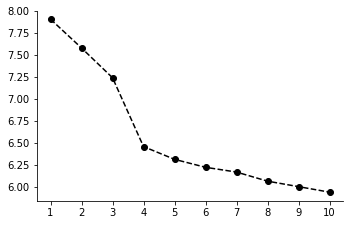

In [78]:
figsize = (5.5,3.5)
plt.figure(figsize=figsize)


counts = 1 + np.array(list(range(num_components)))
plt.plot(counts, eig_values[:num_components], 'o--k')
# plt.ylabel('eigenvalues')
plt.xticks(counts)
box_off()

import os
if not os.path.exists(os.path.join('figure', 'stcl')):
    os.makedirs(os.path.join('figure', 'stcl'))
    
    
plt.savefig(os.path.join('figure', 'stcl', channel_name) + '_nc_eigval.pdf', bbox_inches='tight')

(array([  26.,    0.,    0., 1001., 9007.,    0.,    0.,    0.,    0.,
          28.]),
 array([-25.72089939, -19.52807822, -13.33525705,  -7.14243588,
         -0.9496147 ,   5.24320647,  11.43602764,  17.62884881,
         23.82166998,  30.01449115,  36.20731233]),
 <a list of 10 Patch objects>)

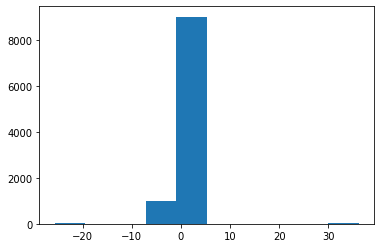

In [79]:
# project
projected = stc.project(data_row, eig_vectors)

plt.hist(projected[:,0])
# plt.hist([projected[:,0], projected[:,1]])

(-28.81730997574518, 39.30372291083438, -6.297443138465255, 36.37928453253633)

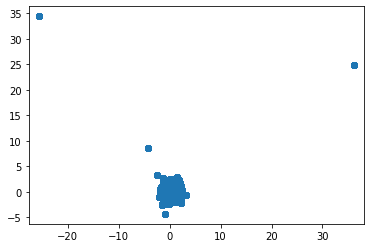

In [80]:
plt.plot(projected[:,0], projected[:,1], 'o')
plt.axis('equal')

In [81]:
# now do clustering
cluster_dim = 2
cl = stcl.fit(projected[:, :cluster_dim])
pred = cl.predict(projected[:, :cluster_dim])

group_centers = stcl.calc_centers(data_row, weights, pred)

In [82]:
# calc inner product of two centers
inner_product = np.dot(group_centers[0].ravel(), group_centers[1].ravel())

# calc PSNRs for the two centers
p2p0, sig0 = pysta.calc_peak_to_peak_and_std(group_centers[0])
p2p1, sig1 = pysta.calc_peak_to_peak_and_std(group_centers[1])

peak-to-peak diff. = 0.37
PSNR = 8.38
peak-to-peak diff. = 0.15
PSNR = 7.25


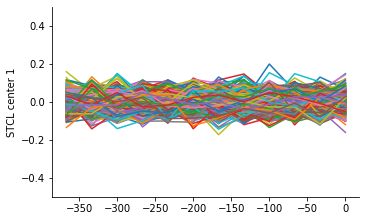

<Figure size 432x288 with 0 Axes>

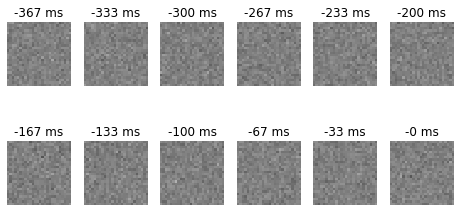

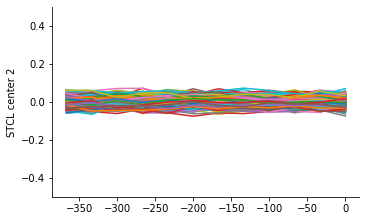

<Figure size 432x288 with 0 Axes>

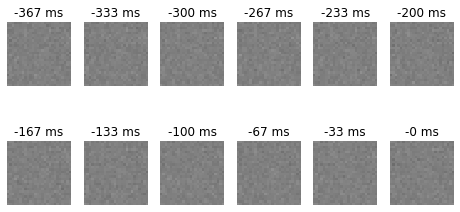

In [83]:
plot_spatio_temporal(group_centers[0].reshape(26*26, -1), ylabel='STCL center 1', 
                     fig_basename=os.path.join('figure', 'stcl', channel_name) + '_center0')

plot_spatio_temporal(group_centers[1].reshape(26*26, -1), ylabel='STCL center 2', 
                     fig_basename=os.path.join('figure', 'stcl', channel_name) + '_center1')

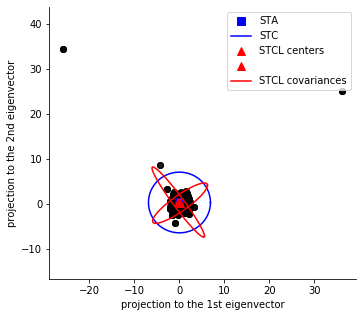

In [84]:
# code from analyze_cluster.ipynb



# project centers
sta_projected = stc.project(sta.ravel(), eig_vectors)
# group_center0_projected = stc.project(group_centers[0], eig_vectors)
# group_center1_projected = stc.project(group_centers[1], eig_vectors)

# plt.figure(figsize=(8, 8))
plt.figure(figsize=(5.5,5))

plt.scatter(projected[:,0], projected[:,1], alpha=0.1, c='k')

plt.plot(sta_projected[0], sta_projected[1], 'sb', markersize=8)

# calc cov mat for plotting ellipse
covariance_mat = stc.calc_covariance_matrix(projected[:,:2], weights=weights, centered=True)
pysta.plot_ellipse(sta_projected[:2], covariance_mat, 'b-')

center0 = cl.means_[0]
plt.plot(center0[0], center0[1], '^r', markersize=8)
center1 = cl.means_[1]
plt.plot(center1[0], center1[1], '^r', markersize=8)

# plt.plot(group_center0_projected[0], group_center0_projected[1], '^r')
# plt.plot(group_center1_projected[0], group_center1_projected[1], '^r')

pysta.plot_ellipse(cl.means_[0], cl.covariances_[0], 'r-')
pysta.plot_ellipse(cl.means_[1], cl.covariances_[1], 'r-')

# remove top & right box
# https://stackoverflow.com/a/28720127
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)





plt.axis('equal')
# plt.xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
# plt.yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])


# plt.xlim(-4.5, 4.5)
# plt.ylim(-4.5, 4.5)


# plt.savefig(os.path.join('figure', dataset + "_" + channel_name + "_projection_no_legend.pdf"))
# plt.savefig(os.path.join('figure', dataset + "_" + channel_name + "_projection_no_legend.png"))

plt.xlabel("projection to the 1st eigenvector")
plt.ylabel("projection to the 2nd eigenvector")
plt.legend(["STA", "STC", "STCL centers", None, "STCL covariances"]) #, loc="upper left")

# plt.savefig(os.path.join('figure', dataset + "_" + channel_name + "_projection.pdf"))
# plt.savefig(os.path.join('figure', dataset + "_" + channel_name + "_projection.png"))




## Run STCL for all RGCs

First, run `run_stcl_batch.py`(offline).
Then, run the following cells for analysis

In [32]:
# idx_on_off = info['cell_type'] == 'ON-OFF'
# channel_names = info[idx_on_off]['channel'].to_list()

p2ps = list()
psnrs = list()
for ch_idx in range(len(info)):
    
    channel_name = info.iloc[ch_idx]['channel']
    
    file_path = os.path.join('results', dataset, channel_name + '.npz')
    print(channel_name)
    
    results = np.load(file_path)
    sta = results['sta'].reshape(26,26,-1)
    center1 = results['group_centers'][0].reshape(26,26,-1)
    center2 = results['group_centers'][1].reshape(26,26,-1)
    
    print(p2p(sta), p2p(center1), p2p(center2))
    p2ps.append([p2p(sta), p2p(center1), p2p(center2)])
    
    print(psnr(sta), psnr(center1), psnr(center2))
    psnrs.append([psnr(sta), psnr(center1), psnr(center2)])
    
    
p2ps = np.array(p2ps)
psnrs = np.array(psnrs)

# save to info
info['sta_p2p'] = p2ps[:,0]
info['center1_p2p'] = p2ps[:,1]
info['center2_p2p'] = p2ps[:,2]

info['sta_psnr'] = psnrs[:,0]
info['center1_psnr'] = psnrs[:,1]
info['center2_psnr'] = psnrs[:,2]

13a
0.12007788836001726 0.11962513781697909 1.0
7.00525155058526 6.952121582784659 6.244258639993106
13b
0.1265443654062149 0.8409961685823755 0.12989568982483768
6.978080427720747 7.411202196092163 7.150768372905994
14a
0.1281219591307169 0.1281219591307169 nan
6.9240265392335045 6.9240265392335045 nan
16a
0.11437630753138078 0.12064883381189867 0.9393010423053342
6.7115263253685935 7.037953436513918 7.418204720835985
17a
0.15014546228624143 0.14755467800729039 0.8389189189189189
7.547576105004577 7.519725183731784 7.130363602376573
21a
0.12388804512909524 0.12430608468488086 1.0
6.7989943995763165 6.8089538670579755 2.9860517923584435
22a
0.17304656669297552 0.8938388625592417 0.1579575869878525
9.249334461229108 7.253734965431863 8.426998484242546
22b
0.1704634108285224 0.15688043299983595 0.8125
9.11616966335015 8.398247141377885 7.1476548942008025
23a
0.13624294722867575 1.0 0.1326577089501253
7.7473862155333295 7.429891753946771 7.519323373040837
23b
0.21107594936708868 0.2110759

In [34]:
info

,channel,cell_type,sta_p2p,center1_p2p,center2_p2p,sta_psnr,center1_psnr,center2_psnr
0,13a,ON,0.120078,0.119625,1.000000,7.005252,6.952122,6.244259
1,13b,ON,0.126544,0.840996,0.129896,6.978080,7.411202,7.150768
2,14a,ON-OFF,0.128122,0.128122,NaN,6.924027,6.924027,NaN
3,16a,Unknown,0.114376,0.120649,0.939301,6.711526,7.037953,7.418205
4,17a,ON-OFF,0.150145,0.147555,0.838919,7.547576,7.519725,7.130364
...,...,...,...,...,...,...,...,...
80,85a,ON-OFF,0.169087,0.169087,NaN,7.878006,7.878006,NaN
81,85b,ON-OFF,0.351080,0.335518,1.000000,10.787246,10.684885,5.959083
82,86a,ON-OFF,0.160101,0.156561,1.000000,7.932275,7.773023,2.780876
83,87a,Unknown,0.238866,0.224035,0.862526,11.859607,11.193089,7.382840


Text(0, 0.5, 'PSNR')

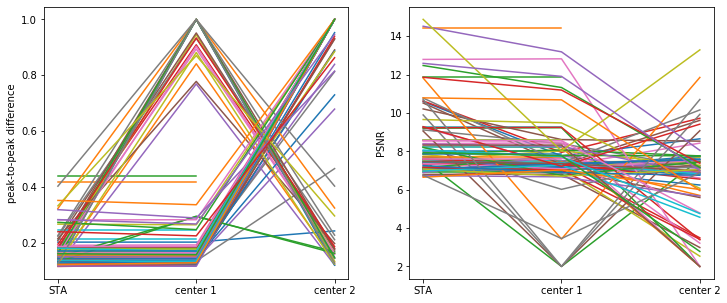

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(['STA', 'center 1', 'center 2'], p2ps.T)
plt.ylabel('peak-to-peak difference')
plt.subplot(122)
plt.plot(['STA', 'center 1', 'center 2'], psnrs.T)
plt.ylabel('PSNR')

In [35]:
info.to_csv(dataset + '_stcl.csv', index=None)
info

,channel,cell_type,sta_p2p,center1_p2p,center2_p2p,sta_psnr,center1_psnr,center2_psnr
0,13a,ON,0.120078,0.119625,1.000000,7.005252,6.952122,6.244259
1,13b,ON,0.126544,0.840996,0.129896,6.978080,7.411202,7.150768
2,14a,ON-OFF,0.128122,0.128122,NaN,6.924027,6.924027,NaN
3,16a,Unknown,0.114376,0.120649,0.939301,6.711526,7.037953,7.418205
4,17a,ON-OFF,0.150145,0.147555,0.838919,7.547576,7.519725,7.130364
...,...,...,...,...,...,...,...,...
80,85a,ON-OFF,0.169087,0.169087,NaN,7.878006,7.878006,NaN
81,85b,ON-OFF,0.351080,0.335518,1.000000,10.787246,10.684885,5.959083
82,86a,ON-OFF,0.160101,0.156561,1.000000,7.932275,7.773023,2.780876
83,87a,Unknown,0.238866,0.224035,0.862526,11.859607,11.193089,7.382840


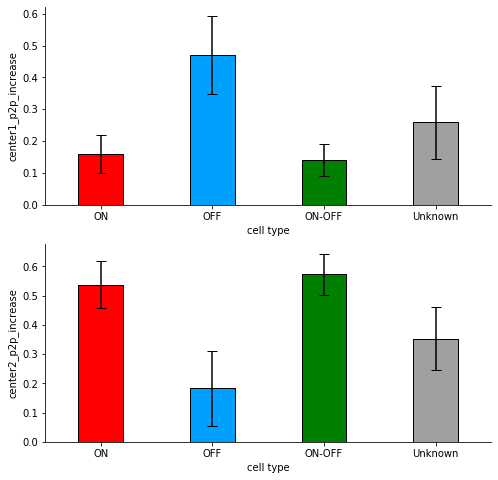

In [66]:
info['center1_p2p_increase'] = info['center1_p2p'] - info['sta_p2p']
info['center2_p2p_increase'] = info['center2_p2p'] - info['sta_p2p']

plt.figure(figsize=(8,8))    
plt.subplot(211)
plot_bar_by_group(info, 'center1_p2p_increase')    
plt.subplot(212)
plot_bar_by_group(info, 'center2_p2p_increase')    
    
plt.savefig("figure/stcl/p2p_increase.pdf", bbox_inches='tight')
plt.savefig("figure/stcl/p2p_increase.png", bbox_inches='tight')

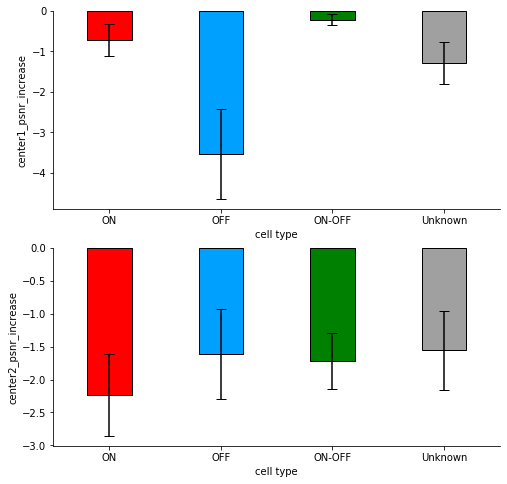

In [65]:
info['center1_psnr_increase'] = info['center1_psnr'] - info['sta_psnr']
info['center2_psnr_increase'] = info['center2_psnr'] - info['sta_psnr']

plt.figure(figsize=(8,8))    
plt.subplot(211)
plot_bar_by_group(info, 'center1_psnr_increase')    
plt.subplot(212)
plot_bar_by_group(info, 'center2_psnr_increase')    
    
plt.savefig("figure/stcl/psnr_increase.pdf", bbox_inches='tight')
plt.savefig("figure/stcl/psnr_increase.png", bbox_inches='tight')